Importing Packages

In [201]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX
from scipy.stats import chi2


import itertools
import warnings
from joblib import Parallel, delayed


Reading File

In [149]:
# Importing the dataset
df = pd.read_csv('Energy_consumption.csv')

# Converting the 'Timestamp' column to datetime format and setting it as the index
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df = df.sort_values('Timestamp')
df.set_index('Timestamp', inplace=True)

# Correcting DayOfWeek
df['DayOfWeek'] = df.index.day_name()

In [150]:
# Clean and preprocess the data
df = df.asfreq('h')

# Choosing size training and testing data
split_index = int(len(df) * 0.8) # 80% of the data for training
test_size = int(len(df) - split_index) # 20% of the data for testing

SARIMA TOY MODEL (no exog variables)

                                     SARIMAX Results                                      
Dep. Variable:                  EnergyConsumption   No. Observations:                  800
Model:             SARIMAX(2, 1, 0)x(2, 1, 0, 24)   Log Likelihood               -2772.466
Date:                            Thu, 15 May 2025   AIC                           5554.931
Time:                                    09:56:15   BIC                           5577.862
Sample:                                01-01-2022   HQIC                          5563.781
                                     - 02-03-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6351      0.037    -17.028      0.000      -0.708      -0.562
ar.L2         -0.2941      0.036   

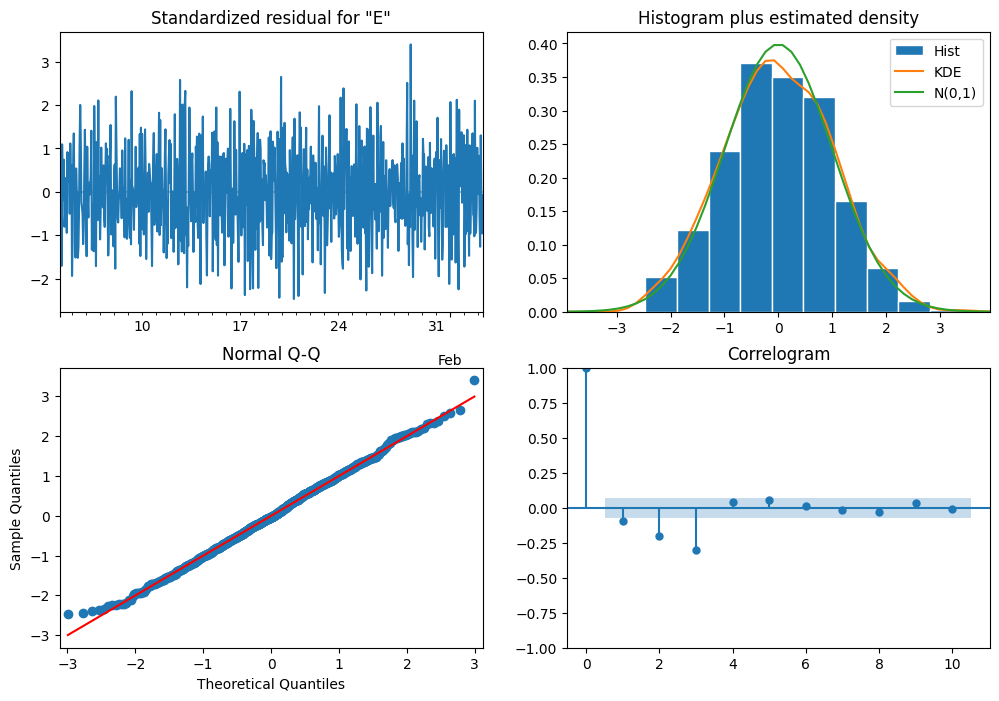

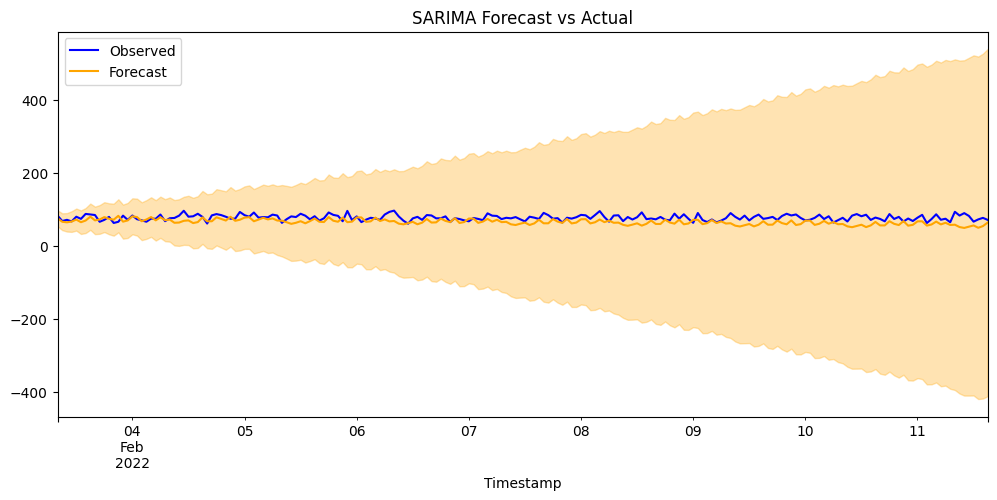

In [193]:
df_train = df['EnergyConsumption'].iloc[:split_index] # training set
y_true = df['EnergyConsumption'].iloc[split_index:] # test set
    # We have only included the EnergyConsumption column for SARIMA model fitting and ignored the other columns

# Fit SARIMA model: This is a toy model for where the order and seasonal_order are chosen intuitively based on EDA and trial and error
model = SARIMAX(df_train,
                order=(2, 1, 0),
                seasonal_order=(2, 1, 0, 24),
                enforce_stationarity=False,
                enforce_invertibility=False)

results = model.fit()

# Step 4: Diagnostics
print(results.summary())
results.plot_diagnostics(figsize=(12, 8))
plt.show()

# Step 5: Forecasting
forecast = results.get_forecast(steps=test_size)
forecast_ci = forecast.conf_int()

# Predicted values (forecasted)
y_pred = forecast.predicted_mean

# Step 6: Plot data and forecast
plt.figure(figsize=(12, 5))
y_true.plot(label='Observed', color='blue')
y_pred.plot(label='Forecast', color='orange')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='orange', alpha=0.3)
plt.title('SARIMA Forecast vs Actual')
plt.legend()
plt.show()

In [194]:
# Evaluation metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred) ** 0.5
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²:   {r2:.4f}")

MAE:  12.93
RMSE: 15.67
MAPE: 16.09%
R²:   -3.0084


SARIMA GRID SEARCH

/Users/tahamalik/Documents/ML/Git/Git/ML-AI-projects/watt-wise/venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/tahamalik/Documents/ML/Git/Git/ML-AI-projects/watt-wise/venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/tahamalik/Documents/ML/Git/Git/ML-AI-projects/watt-wise/venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)
/Users/tahamalik/Documents/ML/Git/Git/ML-AI-projects/watt-wise/venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/tahamalik/Documents/ML/Git/Git/ML-AI-projects/watt-wise/venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: overflow encountered in 


✅ Best model found:
Order:           (2, 0, 2)
Seasonal order:  (0, 2, 2, 24)
AIC:             5139.28

=== Model Summary ===
                                     SARIMAX Results                                      
Dep. Variable:                  EnergyConsumption   No. Observations:                  800
Model:             SARIMAX(2, 0, 2)x(0, 2, 2, 24)   Log Likelihood               -2562.639
Date:                            Thu, 15 May 2025   AIC                           5139.277
Time:                                    10:12:33   BIC                           5171.145
Sample:                                01-01-2022   HQIC                          5151.595
                                     - 02-03-2022                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------

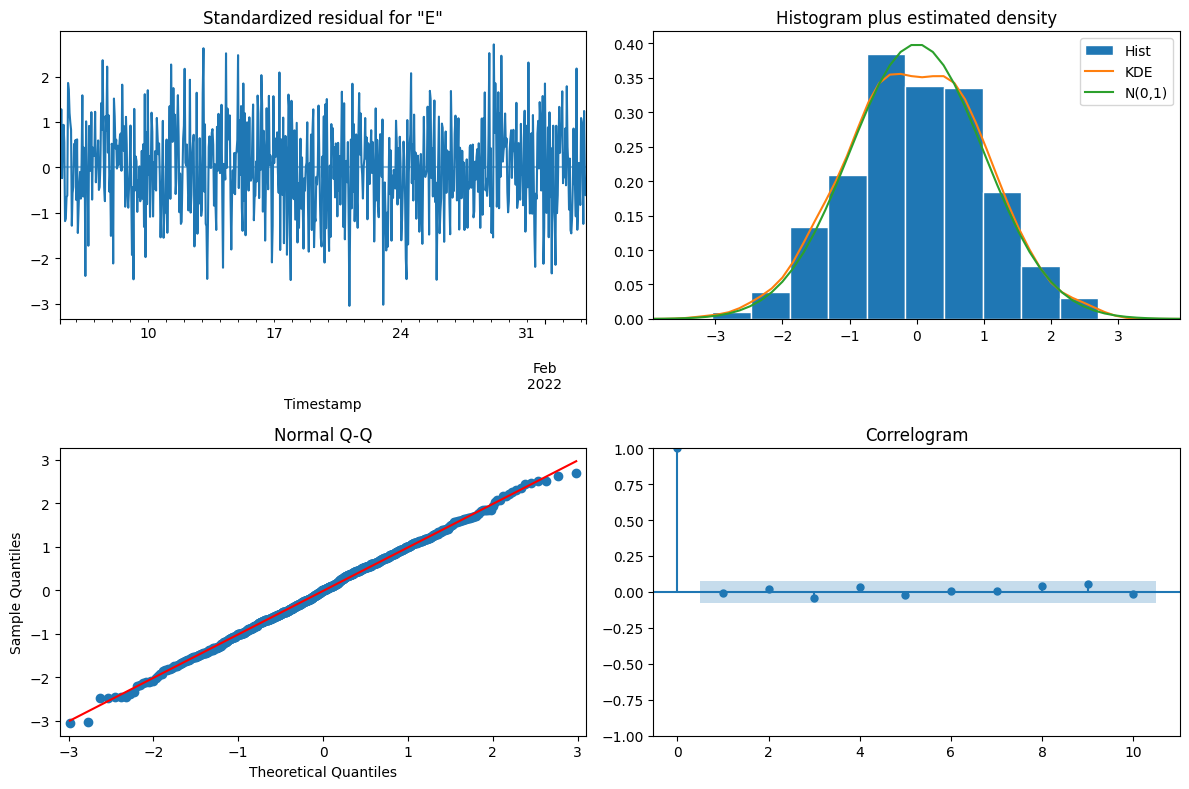

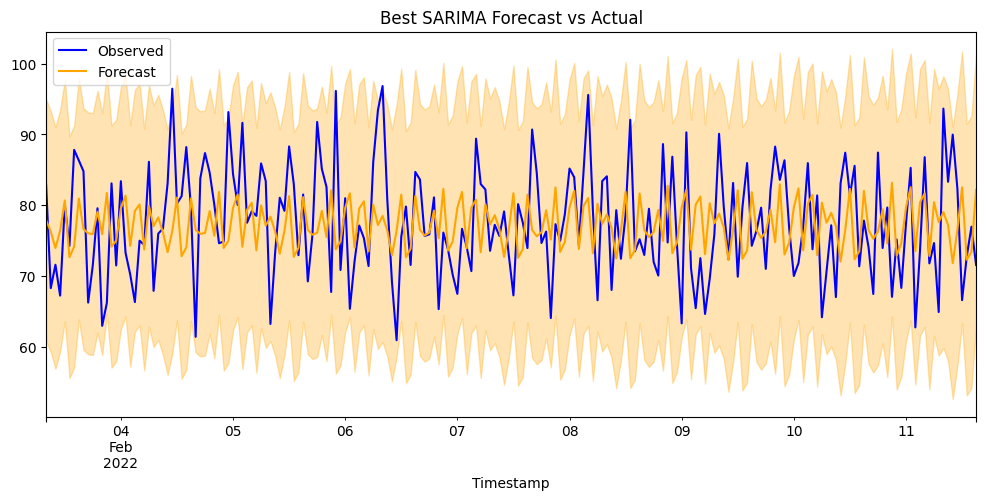

In [195]:
warnings.filterwarnings("ignore")

# Define parameter ranges
p = d = q = range(0, 3)
P = D = Q = range(0, 3)
s = 24  # daily seasonality for hourly data

pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], s) for x in itertools.product(P, D, Q)]

# Define search function
def fit_sarimax(order, seasonal_order):
    try:
        model = SARIMAX(df_train,
                        order=order,
                        seasonal_order=seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        results = model.fit(disp=False)
        return (order, seasonal_order, results.aic)
    except Exception:
        return None

# Run in parallel ---
results = Parallel(n_jobs=-1)(
    delayed(fit_sarimax)(order, seasonal) 
    for order in pdq 
    for seasonal in seasonal_pdq
)

# Filter and find best ---
results = [r for r in results if r is not None]
best_order, best_seasonal_order, best_aic = min(results, key=lambda x: x[2]) # Extract the best model and model parameters

print(f"\n✅ Best model found:")
print(f"Order:           {best_order}")
print(f"Seasonal order:  {best_seasonal_order}")
print(f"AIC:             {best_aic:.2f}")

# === Refit best model ===
best_model = SARIMAX(df_train,
                     order=best_order,
                     seasonal_order=best_seasonal_order,
                     enforce_stationarity=False,
                     enforce_invertibility=False).fit()

# === Show diagnostics ===
print("\n=== Model Summary ===")
print(best_model.summary())
best_model.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()




# Forecast 
forecast = best_model.get_forecast(steps=test_size)
y_pred = forecast.predicted_mean
forecast_ci = forecast.conf_int()


# Plot data and forecast
plt.figure(figsize=(12, 5))
y_true.plot(label='Observed', color='blue')
y_pred.plot(label='Forecast', color='orange')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='orange', alpha=0.3)
plt.title('Best SARIMA Forecast vs Actual')
plt.legend()
plt.show()

In [196]:
# Evaluation metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred) ** 0.5
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²:   {r2:.4f}")

MAE:  6.92
RMSE: 8.56
MAPE: 8.99%
R²:   -0.1958


The updated SARIMA model shows significant improvement over the trial and error version, with lower MAE (6.92), RMSE (8.56), and MAPE (8.99%), indicating better short-term forecasting accuracy. While the R² is still negative (-0.1958), it’s much closer to zero and suggests a better fit. The forecast now tracks the actual values more closely, and the residual diagnostics confirm that the model assumptions are well met—residuals are uncorrelated, normally distributed, and show no systematic patterns. 

The results are somewhat expected since the dataset looks similar to whitenoise.

SARIMAX (including weather info as exog variable)

/Users/tahamalik/Documents/ML/Git/Git/ML-AI-projects/watt-wise/venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/tahamalik/Documents/ML/Git/Git/ML-AI-projects/watt-wise/venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: overflow encountered in matmul
  return _core_matmul(x1, x2)
/Users/tahamalik/Documents/ML/Git/Git/ML-AI-projects/watt-wise/venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: invalid value encountered in matmul
  return _core_matmul(x1, x2)
/Users/tahamalik/Documents/ML/Git/Git/ML-AI-projects/watt-wise/venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: divide by zero encountered in matmul
  return _core_matmul(x1, x2)
/Users/tahamalik/Documents/ML/Git/Git/ML-AI-projects/watt-wise/venv/lib/python3.13/site-packages/numpy/linalg/_linalg.py:3383: RuntimeWarning: overflow encountered in 


✅ Best model found:
Order:           (0, 0, 2)
Seasonal order:  (0, 2, 2, 24)
AIC:             4707.85

=== Model Summary ===
                                     SARIMAX Results                                      
Dep. Variable:                  EnergyConsumption   No. Observations:                  800
Model:             SARIMAX(0, 0, 2)x(0, 2, 2, 24)   Log Likelihood               -2346.924
Date:                            Thu, 15 May 2025   AIC                           4707.848
Time:                                    10:54:00   BIC                           4739.716
Sample:                                01-01-2022   HQIC                          4720.166
                                     - 02-03-2022                                         
Covariance Type:                              opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------

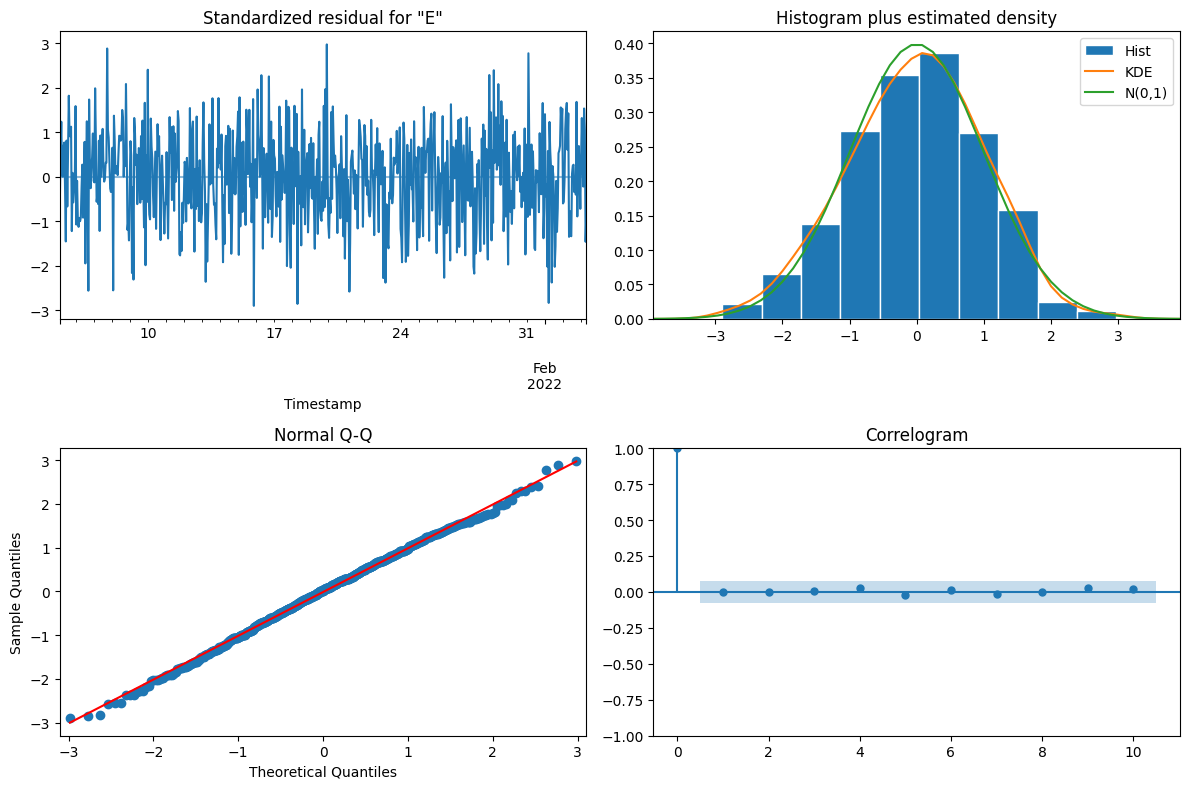

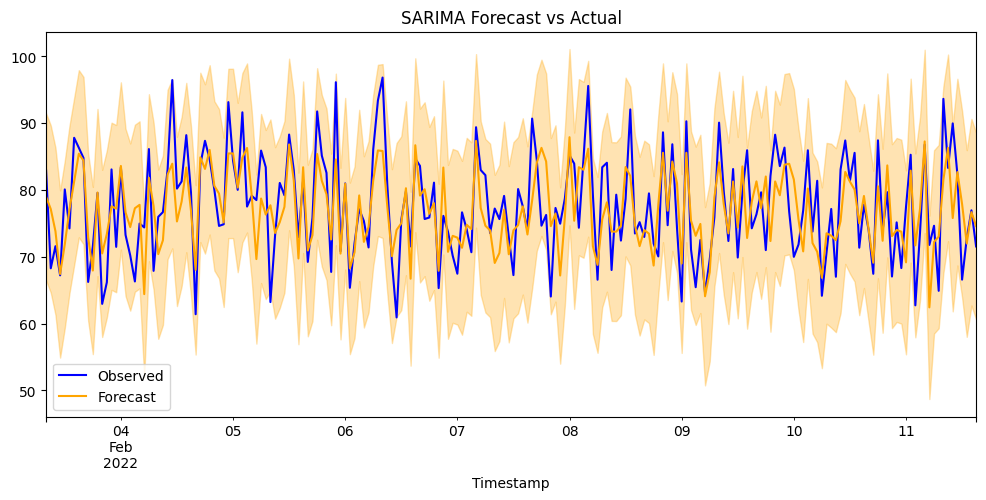

In [199]:
# Splitting the data into training and testing sets (80% train, 20% test)
df_train_target = df['EnergyConsumption'].iloc[:split_index] # training set
df_train_exog = df[['Temperature', 'Humidity']].iloc[:split_index] # training set
y_true = df['EnergyConsumption'].iloc[split_index:] # test set
y_exog = df[['Temperature', 'Humidity']].iloc[split_index:] # test set
    # We have included the Temperarture and Humidity column for SARIMAX model fitting as exog variables   

warnings.filterwarnings("ignore")

# Define parameter ranges ===
p = d = q = range(0, 3)
P = D = Q = range(0, 3)
s = 24  # Seasonality: daily pattern in hourly data

pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], s) for x in itertools.product(P, D, Q)]
all_params = [(order, seasonal) for order in pdq for seasonal in seasonal_pdq]

# Define SARIMAX fitting function ===
def fit_sarimax(order, seasonal_order):
    try:
        model = SARIMAX(df_train_target,
                        exog=df_train_exog,
                        order=order,
                        seasonal_order=seasonal_order,
                        enforce_stationarity=False,
                        enforce_invertibility=False)
        results = model.fit(disp=False)
        return (order, seasonal_order, results.aic)
    except:
        return None

# Run the search in parallel ===
results = Parallel(n_jobs=-1)(
    delayed(fit_sarimax)(order, seasonal)
    for order, seasonal in all_params
)

# Filter valid results and find best ===
results = [r for r in results if r is not None]
best_order, best_seasonal_order, best_aic = min(results, key=lambda x: x[2])

print(f"\n✅ Best model found:")
print(f"Order:           {best_order}")
print(f"Seasonal order:  {best_seasonal_order}")
print(f"AIC:             {best_aic:.2f}")

# Refit best model ===
best_model = SARIMAX(df_train_target,
                     exog=df_train_exog,
                     order=best_order,
                     seasonal_order=best_seasonal_order,
                     enforce_stationarity=False,
                     enforce_invertibility=False).fit()

# Show diagnostics ===
print("\n=== Model Summary ===")
print(best_model.summary())
best_model.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()

# Forecasting
forecast = best_model.get_forecast(steps=test_size, exog=y_exog)
y_pred = forecast.predicted_mean
forecast_ci = forecast.conf_int()


# Plot data and forecast
plt.figure(figsize=(12, 5))
y_true.plot(label='Observed', color='blue')
y_pred.plot(label='Forecast', color='orange')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:, 0],
                 forecast_ci.iloc[:, 1], color='orange', alpha=0.3)
plt.title('SARIMAX Forecast vs Actual')
plt.legend()
plt.show()

In [200]:
# Evaluation metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = mean_squared_error(y_true, y_pred) ** 0.5
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
r2 = r2_score(y_true, y_pred)

print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"R²:   {r2:.4f}")

MAE:  4.60
RMSE: 5.72
MAPE: 5.99%
R²:   0.4661


This latest SARIMAX model, enhanced with weather features, shows a clear improvement in performance. The forecast closely follows actual energy consumption patterns, with MAE reduced to 4.60, RMSE to 5.72, MAPE to 5.99%, and an R² of 0.4661—indicating the model explains nearly half the variance. 

The inclusion of weather data likely helped the model capture external drivers of consumption more accurately. Residual diagnostics confirm the model is well-specified: residuals are uncorrelated, roughly normally distributed, and centered around zero. Overall, this weather-informed SARIMA model is well-suited for accurate short-term forecasting.

However, the SARIMAX results show that all the non-weather related coefficents are not significangtluy different from 0, suggesting that a SARIMAX or order (0,0,0) and seasonal order (0,0,0) might perform similarly, which might be favoured if a similar model is prioritized 

Below is the Evaulation metrics for a SARIMAX[(0,0,0), (0,0,0,24)] model with exogenous variables included

MAE: 4.63
RMSE: 5.96
MAPE: 6.03%
R²: 0.4211

In [210]:
model_1 = SARIMAX(df_train_target,
                     exog=df_train_exog,
                     order=(0,0,0),
                     seasonal_order=(0 ,0, 0, 24),
                     enforce_stationarity=False,
                     enforce_invertibility=False).fit()

llr_stat = -2 * (model_1.llf - best_model.llf)
df_diff = best_model.df_model - model_1.df_model
p_value = chi2.sf(llr_stat, df_diff)

print(f"LLR Statistic: {llr_stat:.2f}")
print(f"Degrees of Freedom: {df_diff}")
print(f"p-value: {p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("✅ The more complex model significantly improves the fit.")
else:
    print("❌ No significant improvement; the simpler model may suffice.")

LLR Statistic: 595.04
Degrees of Freedom: 4
p-value: 0.0000
✅ The more complex model significantly improves the fit.


In summary, the best SARIMAX model offers the highest accuracy, making it the preferred choice when forecasting performance is the top priority. However, the simpler SARIMAX[(0,0,0), (0,0,0,24)] model—despite having no autoregressive or moving average terms—still performs reasonably well, when exogenous variables like temperature and humidity are included.